# Space-time partial differential equation: Study of the diffusive equation (implicit methods)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm 
import importlib
from scipy.optimize import curve_fit
import time
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

importlib.reload(nm)

<module 'nm_lib.nm_lib' from '/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py'>

Let's consider now the viscous term in Burger's equation: 

$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}, \tag{1}$$

## 1- Apply an explicit method. 

What would be the CFL condition for a viscous term where $\nu$ is either a constant or an array that depends on $x$. We would like to solve equation (1) numerically for $x  [x_0, x_f]$ with $x_0 = −2.6$, $x_f = 2.6$, periodic boundary conditions and with the initial condition:

$$u(x,t=t_0) = A\exp(-(x-x_0)^2/W^2)   \tag{2}$$

with $A=0.3$, $W=0.1$, and $x_0=0$. __Suggestion__: Apply the first derivative upwind and the second downwind. Apply Von Newman analysis. Is it stable? What is the time-step dependence with $\Delta x$? 

How many steps are needed to reach a $t=1.8$ for $nump=128$? And $256$? 

In [2]:
def u(x, x0=0, A=0.3, W=0.1):
    ans = A*np.exp(-(x - x0)**2/W**2)
    return ans

def spatial_domain(nump, x0=-2.6, xf=2.6):
    ans = np.arange(nump)/(nump - 1) * (xf - x0) + x0
    return ans

Using the suggestion we get that
$$
\frac{u^{n+1}_{j} - u^{n}_{j}}{\Delta t} = \nu \frac{u_{j+1}^{n} - 2u_{j}^{n} + u_{j-1}^{n}}{\Delta x^2}
$$

Now using the Von Newmann analysis for the equation above.

$$
\begin{align}
    u_{j}^{n} &= \xi^{n} e^{ijk\Delta x}\\
    u_{j}^{n+1} &= \xi^{n+1} e^{ijk\Delta x}\\
    u_{j+1}^n &= \xi^{n} e^{i(j+1)k\Delta x} \\
    u_{j-1}^n &= \xi^{n} e^{i(j-1)k\Delta x} \\
\end{align}
$$
Using $\frac{\nu\Delta t}{\Delta x^2}=\chi$, and $\frac{k\Delta x}{2}=\alpha$
We get the following



$$
\begin{align}
e^{ijk\Delta x}\xi^{n}\frac{\xi - 1}{\Delta t} &= \nu\xi^{n}e^{ijk\Delta x} \frac{e^{ik\Delta x} -2 + e^{-ik\Delta x}}{\Delta x^2}\\
\xi &= \chi\left(e^{ik\Delta x} - 2 + e^{-ik\Delta x}\right) +1\\
\xi &= \chi\left(\cos(k\Delta x) + i\sin(k\Delta x) + \cos(k\Delta x) - i\sin(k\Delta x) -2 \right) +1\\
\xi &= 2\chi\left(\cos(k\Delta x) - 1\right) + 1\\
\xi &= 1 - 4\chi\sin^2\left(\alpha\right)\\
&\Downarrow\nonumber\\
\left|\xi\right|^2 &= 1 - 8\chi\sin^2\left(\alpha\right) + 16\chi^2 \sin^4(\alpha)
\end{align}
$$

Applying the Von Neumann stability analysis criterion
$$
\begin{align*}
\left|\xi\right|^2 &\leq 1\\
16\chi^2\sin^4(\alpha) &\leq 8\chi\sin^2(\alpha)\\
2\chi\sin^2(\alpha) &\leq 1 
\end{align*}
$$
Inserting for $\chi = \frac{\nu\Delta t}{\Delta x^2}$ and using the fact that this should apply for all values of $k$, so can just take the maximum value of $\sin$ which is 1
$$
\begin{align*}
2\frac{\nu\Delta t}{\Delta x^2} &\leq 1\\
\Delta t &\leq \frac{\Delta x^2}{2\nu}
\end{align*}
$$
Which is then is the time step dependence on $\Delta x$ for it to be stable. To reach $t=1.8$, we will then use the maximum value that $\Delta t$ value


In [3]:
nu = 1
nump_list = [128, 256]
for nump in nump_list:
    xx = spatial_domain(nump)

    dx = xx[1] - xx[0] 
    dt = dx**2/(2*nu)
    time_steps = (1.8/(np.min(dt)*np.abs(nu)))

    print(f'The amount of timesteps needed with {nump} is: {time_steps:.2f}')


The amount of timesteps needed with 128 is: 2147.35
The amount of timesteps needed with 256 is: 8657.17


<span style="color:green"> JMS. </span>

<span style="color:blue"> OK. Note that the number of steps (with double resolution) is not double, but quadruple.</span>.

## Choose one of the following options: 

## 2- Implicit methods.

In the [wiki](https://github.com/AST-Course/AST5110/wiki/Implicit-methods), we describe some implicit or semi-explicit methods that allow relaxing the CFL constraint on diffusive terms. Consider Newton-Rapson method and repeat the previous numerical experiment. For this, you will need to implement the following   


$F_j = u^{n+1}_j - u^n_j - \nu \, (u^{n+1}_{j+1} - 2u^{n+1}_{j}+u^{n+1}_{j-1})\frac{\Delta t}{\Delta x^2}$

in `NR_f` and `step_diff_burgers` functions in `nm_lib`. 

And the Jacobian can be easily built. 

$J(j,k) = F_j'(u^{n+1}_k)$

fill in the `jacobian` function in `nm_lib`. Note that this matrix is linear with $u$. 

Test the model with [wiki](https://github.com/AST-Course/AST5110/wiki/Self-similar-solution-for-parabolic-eq) self-similar solutions. How long it takes each time step compared to the Lax-method? Use `time.time` library. Do it for nump=256, nt=30 and dt = 0.1. In order to test the simulation, use `curve_fit` from `scipy.optimize`. 

__hint__ consider to use a good initial guess (`p0`) in and `bnd_limits` to facilitate the fitting wiht `curve_fit`. What happens to the solution when increasing dt? How much can be improved in limiting the tolerance?

### Testing self similiar solutions


In [4]:
xx = spatial_domain(256)
hh = u(xx)
nt = 30
dt = 0.1
a = -1

start = time.time()
nm.evolv_diff_burgers(xx, hh, nt, a=a)
end = time.time()
diff = end-start

start = time.time()
nm.Newton_Raphson(xx, hh, a, dt, nt)
end = time.time()
diff_nr = end-start


Should animate, Newton_raphson. 

----------------------------------------------

Let's consider a non-linear function where $\nu$ depends on $u$. To keep it simple, solve the following: 

$\frac{\partial u}{\partial t} = u \frac{\partial^2 u}{\partial x^2}$

where $\nu_0$ is a constant and the same initial conditions as the previous exercise (fill in `Newton_Raphson_u`, `jacobian_u` and `NR_f_u`. Consider an error limit of $10^{-4}$ and compare the previous exercise (with the same error limit). How many iterations needs now the method to converge to the right solution? Why? Increase `ncount` to 1000. 

## 3- Semi-explicit methods. 

__a)__ Super-time-stepping (STS) schemes work for parabolic terms. STS is an API method that performs a subset of "unstable" intermediate steps, but the sum of all the steps is stable. Visualize how `taui_sts` varies with $nu$ and $niter$. Compare the solution with the analytical one for the final and intermediate STS steps. For the full STS steps, how improves the solution with $nu$? and $niter$? Is there a relation between the error and these two parameters, $nu$, and $niter$? For which $niter$ and $nu$ the method provides larger steps than an ordinary explicit. For this exercise, fill in `evol_sts`, and `taui_sts`. 

In [5]:
def animation(xx, tt, ut, nt, figsize=(10, 5)):
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    def init():
        axes.plot(xx, ut[:, 0])
    
    def animate(i):
        axes.clear()
        axes.plot(xx, ut[:, i])
        axes.set_title(f't={tt[i]:.2f}')
        
    anim = FuncAnimation(fig, animate, interval=1, frames=nt, init_func=init)
    return anim
        

In [6]:
xx = spatial_domain(256)
uu = u(xx)
nt = 20
start = time.time()
t_sts, u_sts, tsts= nm.evolv_sts(xx, uu, nt, 1, nu=0.5) 
print(np.size(u_sts[0, :]), np.size(tsts))
end = time.time()
diff = end-start
print(diff)

start = time.time()
t, un = nm.evolv_Lax_uadv_burgers(xx, uu, nt, 1)
end = time.time()
diff = end-start
print(diff)

20 171
0.03338789939880371
0.004164457321166992


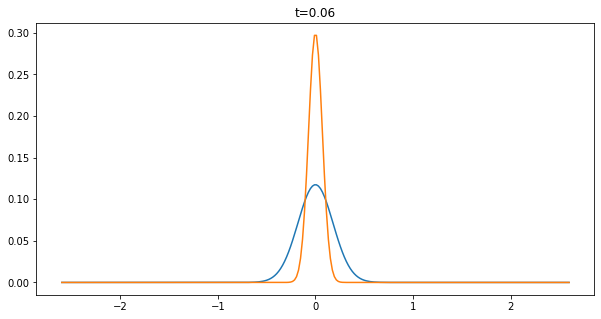

In [7]:
anim = animation(xx, t_sts, u_sts, nt)
HTML(anim.to_jshtml())

Observe that for $\nu$ equal to 1 that it is diffusive.

In [8]:
N = 10
tau_1 = np.zeros(N)
tau_3 = np.zeros(N)
tau_5 = np.zeros(N)
tau_9 = np.zeros(N)

iter = np.arange(1, 11)

for i in range(N):
    tau_1[i] = nm.taui_sts(0.1, 10, iter[i])
    tau_3[i] = nm.taui_sts(0.3, 10, iter[i])
    tau_5[i] = nm.taui_sts(0.5, 10, iter[i])
    tau_9[i] = nm.taui_sts(0.9, 10, iter[i])

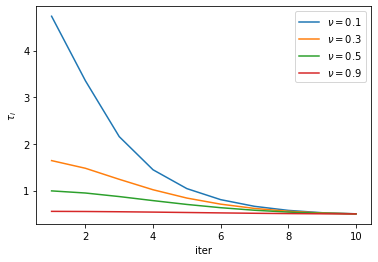

In [9]:
plt.plot(iter, tau_1, label=r'$\nu = 0.1$')
plt.plot(iter, tau_3, label=r'$\nu = 0.3$')
plt.plot(iter, tau_5, label=r'$\nu = 0.5$')
plt.plot(iter, tau_9, label=r'$\nu = 0.9$')
plt.legend()
plt.xlabel('iter')
plt.ylabel(r'$\tau_{i}$')
plt.show()

In [10]:
def gauss(xx, A, mu, sigma, C):
    ans = A*np.exp(-.5*(xx - mu)**2/sigma**2) + C
    return ans

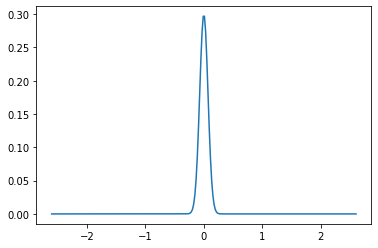

In [11]:
plt.plot(xx, u_sts[:, 0])
plt.show()

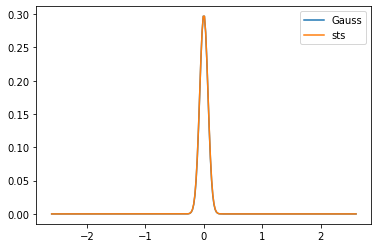

In [12]:
gauss_u = gauss(xx, A=0.3, mu=0, sigma=0.07, C=0)
plt.plot(xx, gauss_u, label='Gauss')
plt.plot(xx, u_sts[:, 0], label='sts')
plt.legend()
plt.show()

In [13]:
M = nt
sigma = np.zeros(M)
A = np.zeros(M)
C = np.zeros(M)
mu = np.zeros(M)
# Max A utsts, location utsts[max A], init sigma|inside p0
# plot xx u_sts for several timestep
# plot the corresponding gauss
pop = []
for i in range(M):
    popt, pcov = curve_fit(gauss, xx, u_sts[:, i], p0=[0.3, 0, 0.7, 0])
    A[i], mu[i], sigma[i], C[i] = popt
    pop.append(popt)

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [20]:
max_A_t1 = A[N]/t_sts[N]**(-1/2)
max_sigma_t1 = sigma[N]/t_sts[N]**(1/2)

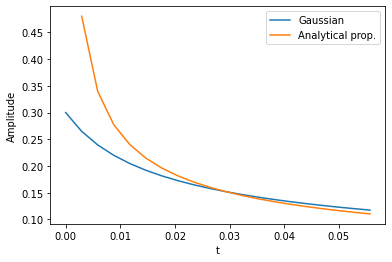

In [15]:
plt.plot(t_sts[:M], A[:], label="Gaussian")
plt.plot(t_sts[1:M], max_A_t1*t_sts[1:M]**(-1/2), label="Analytical prop.")
plt.legend()
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.show()


Observe that they follow more or less the same path. And that they then have the same decrease dependence on time.

<span style="color:green"> JMS. </span>.

<span style="color:blue"> Ok, </span>.

<span style="color:red"> but this can also be done for width. It is also important to notice what is the time-step (number of steps) benefits of the STS. </span>.



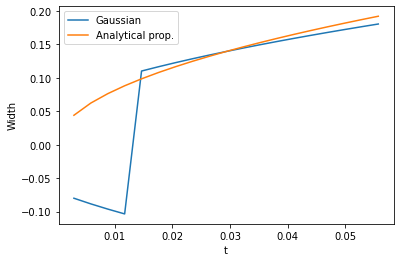

In [23]:
plt.plot(t_sts[1:M], sigma[1:], label="Gaussian")
plt.plot(t_sts[1:M], max_sigma_t1*t_sts[1:M]**(1/2), label="Analytical prop.")
plt.legend()
plt.xlabel("t")
plt.ylabel("Width")
plt.show()

See that the gaussian follows along the analytical width roughly after 0.01 seconds. 

Overall the `sts` intuitivly should be slower because of the introduction of a double `for` loop and trigonemtric calculations. It has the potential to be $n$ times faster than normal CFL criterion, but this is dependent on the free parameter $\nu$.